# Requirements
```
scikit-learn == 0.24.1
seaborn == 0.11.2
numpy == 1.19.5
matplotlib == 3.1.1
pandas == 1.1.0
```
# Dataset inspection
Read in the data.

The dataset contains 776 data samples where there is 1 missing value in Money_Value.

In [276]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [277]:
audit = pd.read_csv('./fraud_audit/audit_risk_data.csv', header=0)
audit.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   776 non-null    float64
 1   LOCATION_ID    776 non-null    object 
 2   PARA_A         776 non-null    float64
 3   PARA_B         776 non-null    float64
 4   numbers        776 non-null    float64
 5   Money_Value    775 non-null    float64
 6   District_Loss  776 non-null    int64  
 7   History        776 non-null    int64  
 8   Score          776 non-null    float64
 9   Risk           776 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 60.8+ KB


In [278]:
audit.head(8)

,Sector_score,LOCATION_ID,PARA_A,PARA_B,numbers,Money_Value,District_Loss,History,Score,Risk
0,3.89,23,4.18,2.50,5.0,3.38,2,0,2.4,1
1,3.89,6,0.00,4.83,5.0,0.94,2,0,2.0,0
2,3.89,6,0.51,0.23,5.0,0.00,2,0,2.0,0
3,3.89,6,0.00,10.80,6.0,11.75,2,0,4.4,1
4,3.89,6,0.00,0.08,5.0,0.00,2,0,2.0,0
5,3.89,6,0.00,0.83,5.0,2.95,2,0,2.0,0
6,3.89,7,1.10,7.41,5.0,44.95,2,0,3.2,1
7,3.89,8,8.50,12.03,5.5,7.79,2,0,4.2,1


### Stats
The describe function gives some basic stats of the numerical features from which the maximum values in PARA_A, PARA_B, Money_Value are apparently out of the normal range. These extream values will be examined and removed later.

In [279]:
audit.describe().T

,count,mean,std,min,25%,50%,75%,max
Sector_score,776.0,20.184536,24.319017,1.85,2.37,3.890,55.570,59.85
PARA_A,776.0,2.450194,5.678870,0.00,0.21,0.875,2.480,85.00
PARA_B,776.0,10.799988,50.083624,0.00,0.00,0.405,4.160,1264.63
numbers,776.0,5.067655,0.264449,5.00,5.00,5.000,5.000,9.00
Money_Value,775.0,14.137631,66.606519,0.00,0.00,0.090,5.595,935.03
District_Loss,776.0,2.505155,1.228678,2.00,2.00,2.000,2.000,6.00
History,776.0,0.104381,0.531031,0.00,0.00,0.000,0.000,9.00
Score,776.0,2.702577,0.858923,2.00,2.00,2.400,3.250,5.20
Risk,776.0,0.393041,0.488741,0.00,0.00,0.000,1.000,1.00


### Box plot
The box plot also shows the same finding.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

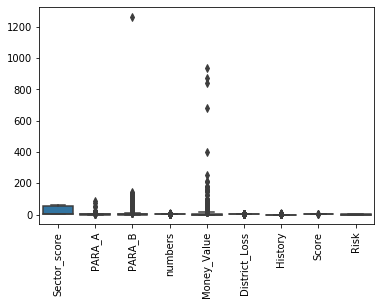

In [280]:
sns.boxplot(data=audit)
plt.xticks(rotation='vertical')

### Histogram & KDE plot

Histogram and KDE plot visualize the feature distribution.

The distribution of Sector_score is polarized, either gathering above 0 or slightly below 60. Different encoding strategies such as binning worth investigating.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7ece47dc50>,
      dtype=object)

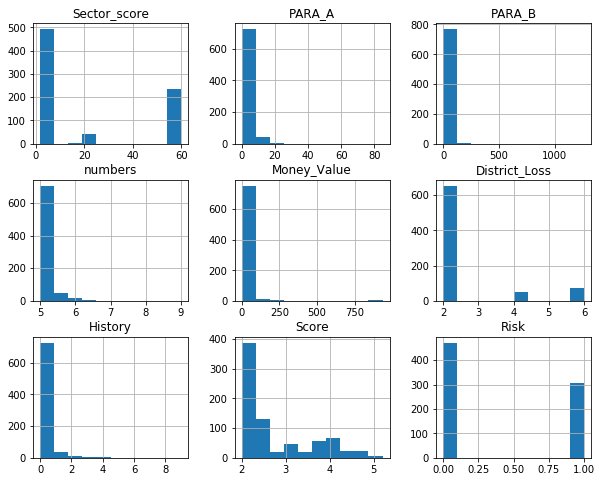

In [281]:
audit.hist(figsize=(10,8))

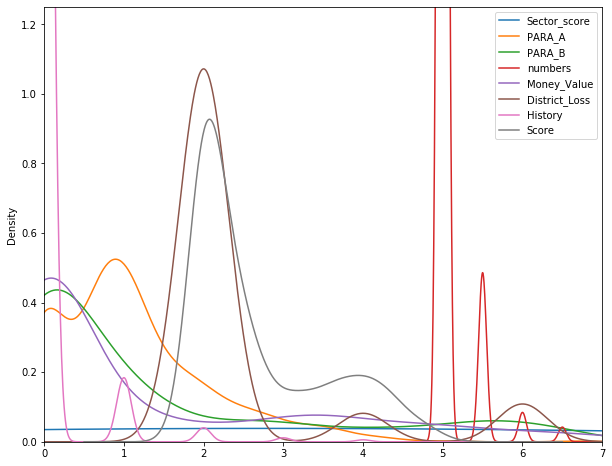

In [304]:
audit.drop('Risk', axis=1).plot.kde(figsize=(10,8), xlim=(0,7), ylim=(0,1.25))

### Pair plot
The pair plot shows:
* the large discrepancy in PARA_A and PARA_B indicate higher risk.
* the similar pattern can be seen in Money_Value and Score ...
* the large feature values, except in Sector_Score, indicate higher risk.

<Figure size 1800x1500 with 0 Axes>

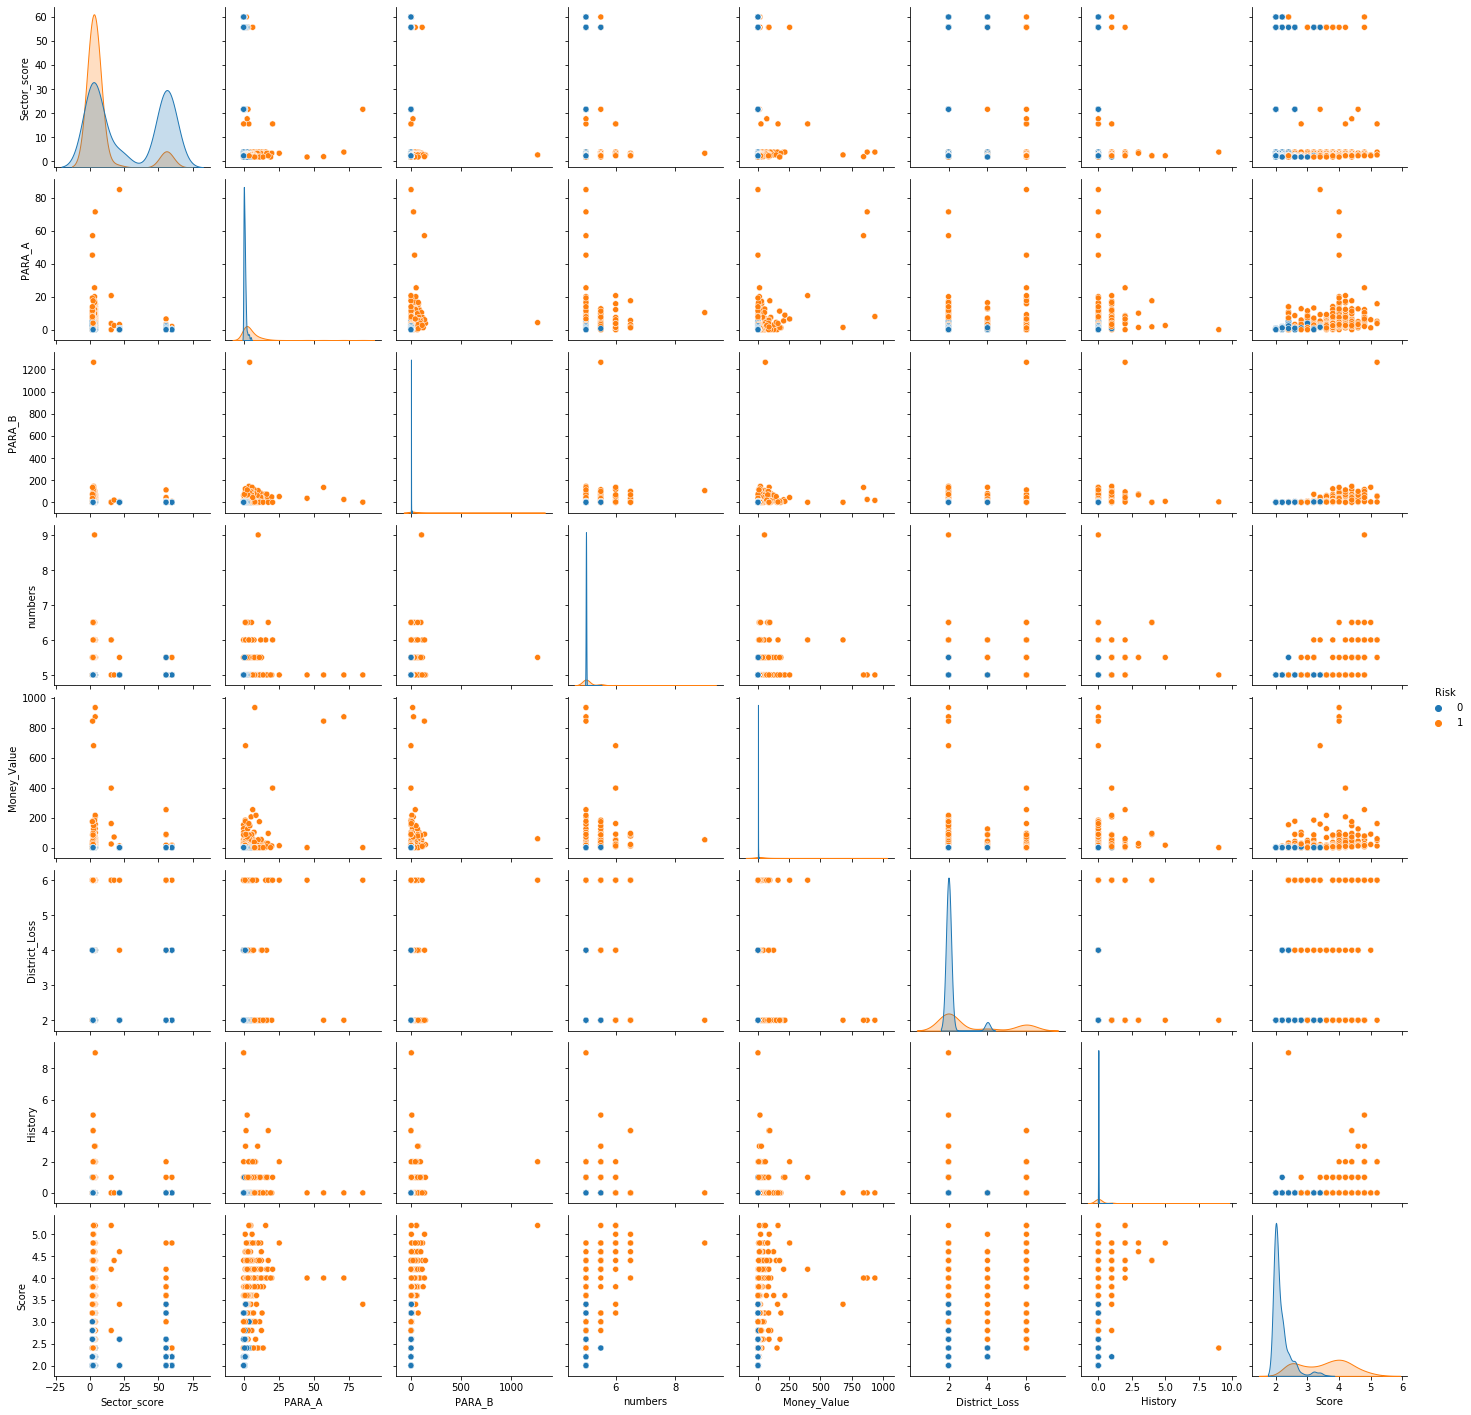

In [283]:
plt.figure(figsize=(12,10), dpi=150)
sns.pairplot(audit, hue='Risk')

## Data cleaning & preprocessing

For data cleaning, we will deal with the missing values and the outliers.

To preprocess, we standardize the features into Normal distribution.

And last, the long tail problem in both PARA_B and Money_Value is investigated.

### Removing extream values
The purpose of removing such values is to avoid including wrong data points which may cause by manual error.

We define the IQR as the gap between quartile 1 (Q1) and quartile 3 (Q3).

Given the stats, a data point is below $Q1 − 1.5*IQR$ or above $Q3 + 1.5*IQR$, it is viewed as being too far from the central values to be reasonable. Therefore they are removed.

A threshold is defined to prevent dropping too many samples at one removal.

In [284]:
threshold = int(0.005 * len(audit))
stats = audit.describe().T
for col in stats.index:
    IQR = stats.loc[col]['75%'] - stats.loc[col]['25%']
    lower = stats.loc[col]['25%'] - 1.5 * IQR
    high = stats.loc[col]['75%'] + 1.5 * IQR
    outliers = audit[(audit[col] < lower) | (audit[col] > high)].nlargest(threshold, col).index
    if len(outliers):
        audit = audit.drop(outliers, axis=0)
        print(f'remove {len(outliers)} outliers in {col}.')
        

remove 3 outliers in PARA_A.
remove 3 outliers in PARA_B.
remove 3 outliers in numbers.
remove 3 outliers in Money_Value.
remove 3 outliers in District_Loss.
remove 3 outliers in History.
remove 2 outliers in Score.


(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

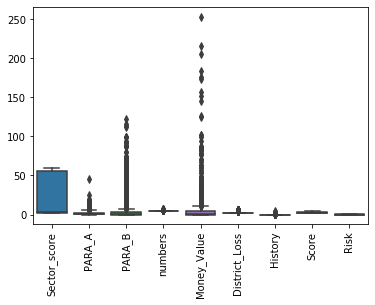

In [285]:
sns.boxplot(data=audit)
plt.xticks(rotation='vertical')

#### The Long tail problem

As these data points are analyzed, an interesting fact shows **100% of the data is labelled as Risk** if PARA_B > 7.37 or Money_Value > 8.21.

This can be viewed as a strong indicator, therefore we shouldn't simply remove it as outliers. Instead, we apply **log normalization** on these data points to alleviate the long tail, since they represent expenditure and money.

Note: 1 is added to avoid negative values.

For PARA_A **square root transformation** is applied to reduce the long tail.

In [286]:
audit[audit['Risk'] == 0]['PARA_B'].nlargest(1)

79    7.37
Name: PARA_B, dtype: float64

In [287]:
audit[audit['Risk'] == 0]['Money_Value'].nlargest(1)

266    8.21
Name: Money_Value, dtype: float64

In [288]:
audit['PARA_A'] = np.sqrt(audit['PARA_A'])
audit['PARA_B'] = np.log2(audit['PARA_B'] + 1)
audit['Money_Value'] = np.log2(audit['Money_Value'] + 1)

#### Re-inspecting (imbalanced data)

The final inspection shows the resulting dataset contains 470 negative samples and 261 positive samples. 

The imbalanced dataset problem could be solved by up-sampling or down-sampling methods such as SMOTE or Tomeklinks...

However, considering fraud samples are also rare in the real world, the resampling is skipped. Instead, the imbalance problem will be addressed by cost-sensitive learning.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

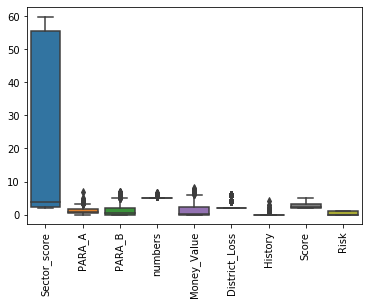

In [289]:
sns.boxplot(data=audit)
plt.xticks(rotation='vertical')

In [290]:
audit.value_counts('Risk')

Risk
0    471
1    285
dtype: int64

### Dropping missing values.
For missing values, we can either discard them or impute the approximation with stats. In this case, since we have only 1 missing value in Money_Value feature, we could simply drop it.

In [291]:
audit = audit.dropna(axis=0, subset=['Money_Value'])
audit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 0 to 775
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sector_score   755 non-null    float64
 1   LOCATION_ID    755 non-null    object 
 2   PARA_A         755 non-null    float64
 3   PARA_B         755 non-null    float64
 4   numbers        755 non-null    float64
 5   Money_Value    755 non-null    float64
 6   District_Loss  755 non-null    int64  
 7   History        755 non-null    int64  
 8   Score          755 non-null    float64
 9   Risk           755 non-null    int64  
dtypes: float64(6), int64(3), object(1)
memory usage: 64.9+ KB


### Data standardization


In [292]:
from sklearn.preprocessing import StandardScaler

In [293]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(audit.drop(['LOCATION_ID', 'Risk'], axis=1))
scaled_features

array([[-0.68015546,  0.9922659 ,  0.21467875, ..., -0.39900723,
        -0.2150128 , -0.31994813],
       [-0.68015546, -1.13812019,  0.59236023, ..., -0.39900723,
        -0.2150128 , -0.80696596],
       [-0.68015546, -0.39397913, -0.55936698, ..., -0.39900723,
        -0.2150128 , -0.80696596],
       ...,
       [ 1.43198985, -0.62764364, -0.68356488, ..., -0.39900723,
        -0.2150128 , -0.80696596],
       [ 1.43198985, -0.67212099, -0.71259539, ..., -0.39900723,
        -0.2150128 , -0.80696596],
       [ 1.43198985, -1.13812019, -0.71259539, ..., -0.39900723,
        -0.2150128 , -0.80696596]])

# Feature engineering
In this step, we perform basic feature selection and feature encoding.

## Feature selection
The data consist of 9 features, where 8 of them are numerical and the LOCATION_ID is categorical. 
Afterwards, feature encoding is performed.

### Numerical
For numerical features, we examine the feature importance by Pearson correlation.

As the feature correlation is shown, the numerical features are positively correlated with the target overall. The correlation between features is weak (**no multicollinearity**).

Comparably, 'History' and 'numbers' have low correlation (0.27 and 0.32), but at this moment, considering the limited number of features, they will be included.

In addition, although they weakly correlate with the target respectively, these features may interact well with other features during prediction.


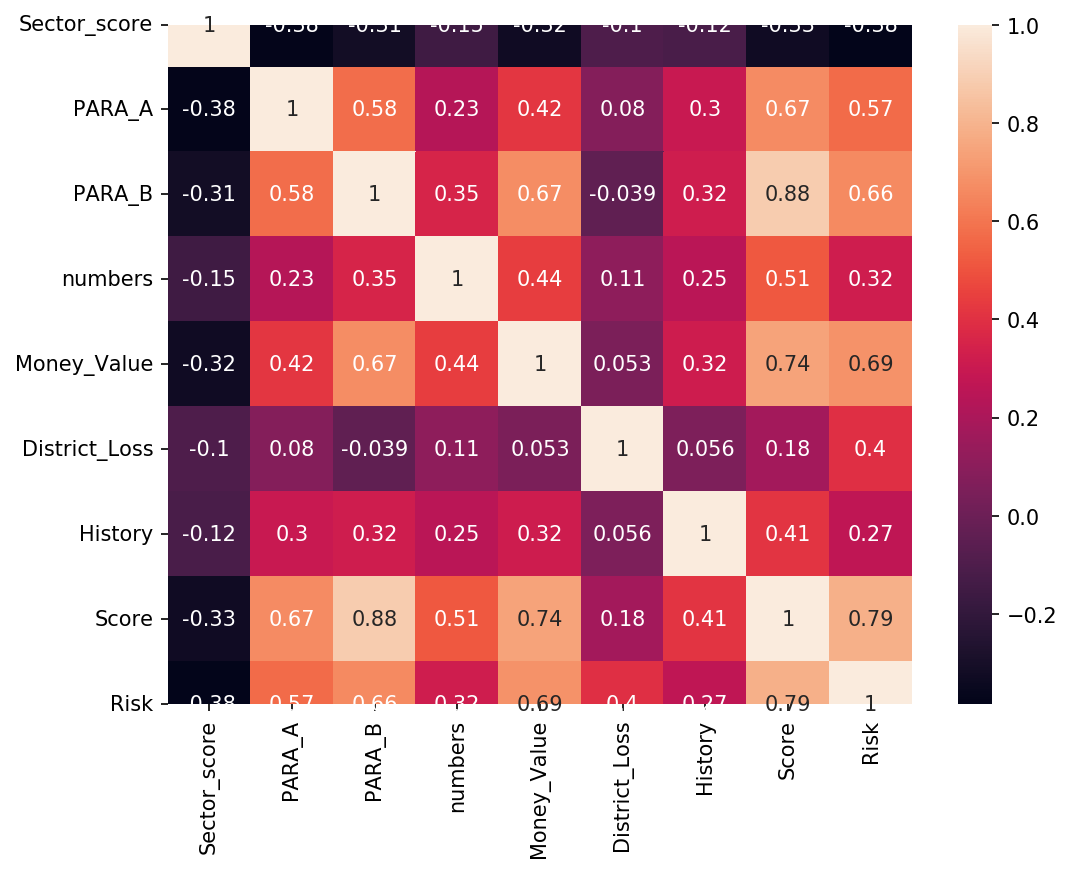

In [294]:
plt.figure(figsize=(8,6), dpi=150)
sns.heatmap(audit.corr(), annot=True)
# sns.pairplot(audit)

### Categorical
For the categorical feature, LOCATION_ID, empirically, locations may give certain information about the policy, events, financial status of that region. It should also be included.

## Feature encoding

In [295]:
len(audit['LOCATION_ID'].value_counts())

45

LOCATION_ID contains 45 unique values. Using one-hot encoding increases the feature space by the same amount of numbers, resulting in a sparse matrix, which may cause underperforming.
### Feature hashing
Assume that some locations share similar characteristics. It is reasonable to bin the feature by the geo info, or use feature hashing to encode. Since at this moment we lack of geo info, feature hashing will be used.

In [296]:
from sklearn.feature_extraction import FeatureHasher

In [297]:
hasher = FeatureHasher(n_features=4, input_type="string")
hashed_features = hasher.fit_transform(audit['LOCATION_ID'])
hashed_features.toarray()

array([[ 1.,  0.,  0.,  1.],
       [ 1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.],
       ...,
       [-1., -1.,  0.,  0.],
       [ 0., -2.,  0.,  0.],
       [ 1., -1.,  0.,  0.]])

# Modelling

The dataset is splitted by 8:2 as a training and validation set.
The validation set is later used for evaluating the prediction model.

In [298]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [299]:
X = np.concatenate([scaled_features, hashed_features.toarray()], axis=1)
y = audit['Risk']
X_train, X_vali, y_train, y_vali = train_test_split(X, y, test_size=0.2, random_state=29)

## Training & Evaluation
### Model selection
Given those visualizations and the assumption of no multicollinearity, logistic regression can be a reasonable baseline model in this case. It runs fast, well-explained and suitable for a classification task with supervised data.

To prevent it from overfitting, **L2 regularization** is added. As mentioned, the **class weight** for the minority class is lifted. We tune the hyper parameters via grid search.

### Evaluation
The dataset is **imbalanced**, precision, recall or F1 can be used.


**Type II** error is more expensive than type I error in risk prediction in general. The bank may suffer from loss if predicting a high risk firm to be low risk. However, under particular circumstances, it is also not good to have a strict policy all the time which may lead to low revenue. At that moment, we could adjust the evaluation metrics from recall to precision.

At last, an ROC curve is shown.

### Hyper-parameter tuning with grid search
The model is evaluated on the validation set. To search better hyper-parameters, a grid search with cross validation is applied.

In [300]:
params = {
    'C': np.arange(0.2, 1.0, 0.2),
    'class_weight': [{0: 1.0, 1: ratio} for ratio in np.arange(1.0, 2, 0.25)],
}
clf = GridSearchCV(estimator=LogisticRegression(), param_grid=params, cv=5, scoring='recall').fit(X_train, y_train)
clf.best_estimator_

LogisticRegression(C=0.8, class_weight={0: 1.0, 1: 1.75})

### Training a final model & Evaluation
The grid search gives us a set of local optimal parameters, which is then used for training a final model on the whole training data.

In [301]:
clf = LogisticRegression(penalty='l2', C=0.8, class_weight={0: 1, 1: 1.75}, random_state=29).fit(X_train, y_train)
pred = clf.predict(X_vali)
print(classification_report(y_pred=pred, y_true=y_vali))
print('recall', classification_report(y_pred=pred, y_true=y_vali, output_dict=True)['1']['recall'])

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        91
           1       0.91      0.97      0.94        60

    accuracy                           0.95       151
   macro avg       0.94      0.95      0.95       151
weighted avg       0.95      0.95      0.95       151

recall 0.9666666666666667


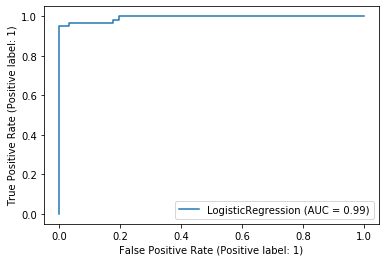

In [302]:
plot_roc_curve(clf, X_vali, y_vali)

#### Coefficient analysis
The coefficients indicate PARA_A, PARA_B, Money_Value, District_Loss and Score are key features, with large coefficients.

To investigate further, linear SVM, L1 penalty logistic regression can be uesd for feature analysis to carry out more explainable results.

In [303]:
clf.coef_

array([[-0.32667417,  2.19323362,  1.49683744, -0.01229813,  3.10914535,
         2.4757199 ,  0.06072522,  1.5488589 , -0.32712052,  0.38336324,
        -0.02403592,  0.22415904]])

# Future work & Possible improvements
* Investigate different feature encoding such as binning on Sector_score.
* Leverage L1 penalty to select features.
* Use different, complexer model such as SVMs or boosted tree based methods.